# Incorporate marine species to NRC
### In this notebook we incorporate marine data to the updated terrestrial data calculated in the Terrestrial_NRC notebook
May 2022

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import arcgis
from arcgis.gis import GIS
import json
import pandas as pd
from arcgis.features import FeatureLayerCollection
import requests as re
from copy import deepcopy
from itertools import repeat
import functools

## Import, explore and prepare the data

In [2]:
path_mar = '/Users/sofia/Documents/HE_Data/NRC/NRC_Marine'
path_ter = '/Users/sofia/Documents/HE_Data/NRC/NRC_Terrestrial'

In [3]:
# Import tables
gadm = pd.read_csv(f'{path_ter}/NRC_Terrestrial_20240314.csv') # This is the updated gadm_centroid
spi = pd.read_csv(f'{path_mar}/Marine_SPI_by_country_20240314_withGID.csv')# table with spi and protection
mar = pd.read_csv(f'{path_mar}/Marine_SPI_NRCs_202401_expert_withGID_20240314.csv') # Species able provided by Alex (MOL)
perc = pd.read_csv(f'{path_mar}/marine_protection_and_protection_needed.csv')
pop = pd.read_csv(f'{path_mar}/Pop2020_eez.csv') # calculated in arcgis pro using the population2020.crf and the EEZ shapefile
hm = pd.read_csv(f'{path_mar}/marine_perc_human.csv') # human modification table
eez = gpd.read_file(f'{path_mar}/eez_centroids/eez_centroids.shp')

In [4]:
mar

,speciesgroup,species,countryname,GID_0,ISO_SOV1,percentprotected,NSPS,stewardship
0,marine fishes,Abalistes filamentosus,Australia,AUS,AUS,50-75%,75-100,33
1,marine fishes,Abalistes filamentosus,Brunei,BRN,BRN,0-25%,0-25,33
2,marine fishes,Abalistes filamentosus,Australia,CCK,AUS,0-25%,0-25,33
3,marine fishes,Abalistes filamentosus,China,CHN,CHN,0-25%,0-25,33
4,marine fishes,Abalistes filamentosus,Australia,CXR,AUS,0-25%,0-25,33
...,...,...,...,...,...,...,...,...
357045,marine fishes,Zu elongatus,Gabon,GAB,GAB,0-25%,0-25,9
357046,marine fishes,Zu elongatus,Namibia,NAM,NAM,0-25%,0-25,9
357047,marine fishes,Zu elongatus,New Zealand,NZL,NZL,0-25%,50-75,9
357048,marine fishes,Zu elongatus,International waters,XXZ,XXZ,0-25%,0-25,9


In [5]:
gadm.head(1)

,Unnamed: 0,GID_0,NAME_0,Area_Country,MOL_ID,geometry,x,y,jpg_url,has_priority,...,birds,mammals,reptiles,endemic_amphibians,endemic_birds,endemic_mammals,endemic_reptiles,nspecies_ter,total_endemic_ter,filter_similar_ter
0,0,ABW,Aruba,181.938403,1,POLYGON ((-69.97819519085533 12.46986101877104...,-69.970245,12.509136,https://live.staticflickr.com/1952/31416683438...,1.0,...,58,46,23,0,0,0,1,128,1,"{""filter_Area_Country"": [""JEY"", ""CXR"", ""WLF"", ..."


In [4]:
gadm.continent.unique()

array(['North America', 'Asia', 'Africa', 'Europe', 'South America',
       'Oceania', 'Antarctica', nan], dtype=object)

In [8]:
# Check which countries have the continent as NaN
gadm[gadm.continent.isna()].NAME_0.unique()

array(['Republic of the Congo', 'Cabo Verde', 'Czechia',
       'British Indian Ocean Territory', 'North Macedonia', 'Palestine',
       'Réunion', 'Saint Helena, Ascension and Tristan da Cunha',
       'United States Minor Outlying Islands'], dtype=object)

In [9]:
# Check the GID_0 for the countries with continent as NaN
gadm[gadm.continent.isna()].GID_0.unique()

array(['COG', 'CPV', 'CZE', 'IOT', 'MKD', 'PSE', 'REU', 'SHN', 'UMI'],
      dtype=object)

In [10]:
gadm.loc[gadm.GID_0=='COG', 'continent'] = 'Africa'
gadm.loc[gadm.GID_0=='CPV', 'continent'] = 'Africa'
gadm.loc[gadm.GID_0=='CZE', 'continent'] = 'Europe'
gadm.loc[gadm.GID_0=='IOT', 'continent'] = 'Asia'
gadm.loc[gadm.GID_0=='MKD', 'continent'] = 'Europe'
gadm.loc[gadm.GID_0=='PSE', 'continent'] = 'Asia'
gadm.loc[gadm.GID_0=='REU', 'continent'] = 'Africa'
gadm.loc[gadm.GID_0=='SHN', 'continent'] = 'Africa'
gadm.loc[gadm.GID_0=='UMI', 'continent'] = 'North America'
gadm.continent[gadm.GID_0=='CZE']

58    Europe
Name: continent, dtype: object

In [12]:
gadm.continent.unique()

array(['North America', 'Asia', 'Africa', 'Europe', 'South America',
       'Oceania', 'Antarctica'], dtype=object)

In [13]:
spi.head(1)

,countryname,GID_0,ISO_SOV1,year,mode,nspecies,SPI_low,SPI_high,percentprotected_low,percentprotected_high
0,Netherlands,ABW,NLD,1980,Expert,1678,0.01,0.01,0.0,0.0


In [14]:
len(spi['GID_0'].unique()) # There are 200 unique countries/territories with SPI data

200

In [16]:
mar.head(1)

,speciesgroup,species,countryname,GID_0,ISO_SOV1,percentprotected,NSPS,stewardship
0,marine fishes,Abalistes filamentosus,Australia,AUS,AUS,50-75%,75-100,33


In [17]:
len(mar['GID_0'].unique()) # There are 155 unique countries/territories with marine species

200

There are two different countrynames associated with the same iso3. MOL wants to keep only the data related to "Republic of Mauritius", so let's remove the "Mauritius" data.

In [18]:
len(mar)

357050

In [19]:
spi = spi[spi.countryname != 'Mauritius']
mar = mar[mar.countryname != 'Mauritius']
len(mar)

354212

In [20]:
mar.countryname[mar.GID_0=='MUS'].unique()

array(['Republic of Mauritius'], dtype=object)

In [21]:
perc.head() # we'll get only the protection needed, the percentage of protection we'll take it from spi

,Unnamed: 0,ISO_TER1_F,Perc_Prot_Need,Perc_Prot
0,1,ABW,7.356267,0.005504
1,2,AGO,7.608244,0.011753
2,3,AIA,1.264193,1.430093
3,4,ALB,32.743156,0.804740
4,5,ARE,56.964522,7.070762


In [20]:
len(perc)

203

In [21]:
pop.head(1)

,OID_,GID_0,ZONE_CODE,COUNT,AREA,SUM
0,1,ABW,1,55.0,0.003819,1547.605201


In [22]:
len(pop) # There are 201 countries/territories that have population in their EEZ

201

In [23]:
hm.head(1)

,Unnamed: 0,ISO_TER1_F,no_human,human,very_high
0,2,ABW,0.0,0.783047,0.216953


In [24]:
len(hm) # There are 203 countries/territories that have human modification data in their EEZ

203

In [25]:
eez.head()

,GID_0,AREA_KM,ORIG_FID,geometry
0,ABW,29970.299588,1,POINT (-69.67341 13.74138)
1,AGO,495859.762742,2,POINT (11.03537 -11.70110)
2,AIA,90157.964205,3,POINT (-62.54329 20.01803)
3,ALB,12165.548773,4,POINT (19.11300 40.92708)
4,ARE,57838.146798,5,POINT (54.03058 25.05891)


In [26]:
len(eez) # There are 202 countries/territories that have EEZ

202

In [22]:
gadm = gadm.drop(columns=['Unnamed: 0'])
gadm.columns

Index(['GID_0', 'NAME_0', 'Area_Country', 'MOL_ID', 'geometry', 'x', 'y',
       'jpg_url', 'has_priority', 'has_raisg', 'GlobalID', 'max_highlited_sp',
       'continent', 'GNI_PPP', 'sentence', 'hm_ter', 'hm_no_ter', 'hm_vh_ter',
       'Global_SPI_ter', 'Pop2020', 'SPI_ter', 'prop_protected_ter',
       'protection_needed_ter', 'amphibians', 'birds', 'mammals', 'reptiles',
       'endemic_amphibians', 'endemic_birds', 'endemic_mammals',
       'endemic_reptiles', 'nspecies_ter', 'total_endemic_ter',
       'filter_similar_ter'],
      dtype='object')

**Clean tables**

In [23]:
# There are more hm countries than eez countries??
list1 = list(eez['GID_0'].unique())
list2 = list(hm['ISO_TER1_F'].unique())
list(set(list2).difference(list1)) # 'TMP' not present in gadm or eez 

['TMP']

In [24]:
# remove TMP from hm
hm = hm[hm.ISO_TER1_F != 'TMP']

In [25]:
# There are more hm countries than eez countries??
list1 = list(eez['GID_0'].unique())
list2 = list(perc['ISO_TER1_F'].unique())
list(set(list2).difference(list1)) # 'TMP' not present in gadm or eez 

['TMP']

In [26]:
# remove TMP from perc
perc = perc[perc.ISO_TER1_F != 'TMP']

In [27]:
# Find GID_0 that are in species table but not in gadm 
list1= list(gadm['GID_0'])
list2=list(mar['GID_0'].unique())
list(set(list2).difference(list1))  # XXZ is international waters

['XXZ']

In [28]:
# remove XXZ from mar
mar = mar[mar.GID_0 != 'XXZ']

In [29]:
# Find GID_0 that are in spi table but not in gadm:
list1= list(gadm['GID_0'])
list2=list(spi['GID_0'].unique())
list(set(list2).difference(list1)) 

['XXZ']

In [30]:
# remove TMP from spi
spi = spi[spi.GID_0 != 'TMP']

In [31]:
# Find GID_0 that are in hm but not in gadm:
list1= list(gadm['GID_0'])
list2=list(hm['ISO_TER1_F'].unique())
list(set(list2).difference(list1)) 

[]

In [32]:
# Find GID_0 that are in population but not in gadm:
list1= list(gadm['GID_0'])
list2=list(pop['GID_0'].unique())
list(set(list2).difference(list1)) 

[]

In [33]:
# Find GID_0 that are in EEZ table but not in gadm
list1= list(gadm['GID_0'])
list2=list(eez['GID_0'].unique())
list(set(list2).difference(list1)) 

[]

**Create "Marine" field in gadm table to identify countries that have eez and those that are only terrestrial**

In [34]:
# Create list with countries that have eez
l = list(eez['GID_0'])

# Give true or false to marine field according to the presence of eez
gadm['Marine'] = gadm['GID_0'].apply(lambda x: any([k in x for k in l]))
gadm['Marine'] = gadm['Marine'].map({True: 'True', False: 'False'})

**Prepare tables**

In [35]:
# Change name of human modification fields to prepare it for join
hm = hm.rename(columns={'ISO_TER1_F':'GID_0', 'no_human':'hm_no_mar', 'human':'hm_mar', 'very_high':'hm_vh_mar'}).drop(columns= {'Unnamed: 0'})
hm.head()

,GID_0,hm_no_mar,hm_mar,hm_vh_mar
0,ABW,0.000000,0.783047,0.216953
1,AGO,0.000223,0.778475,0.221302
2,AIA,0.000000,0.943677,0.056323
3,ALB,0.000263,0.003746,0.995991
4,ARE,0.000116,0.034045,0.965838


In [36]:
# The human modification table was given in 0-1 values, let's make it in % to match the terrestrial data
hm['hm_no_mar'] = hm['hm_no_mar'].apply(lambda x: x*100)
hm['hm_mar'] = hm['hm_mar'].apply(lambda x: x*100)
hm['hm_vh_mar'] = hm['hm_vh_mar'].apply(lambda x: x*100)
hm.head()

,GID_0,hm_no_mar,hm_mar,hm_vh_mar
0,ABW,0.000000,78.304750,21.695250
1,AGO,0.022313,77.847478,22.130209
2,AIA,0.000000,94.367741,5.632259
3,ALB,0.026286,0.374581,99.599133
4,ARE,0.011637,3.404538,96.583825


In [37]:
hm = hm.round(2)
hm.head()

,GID_0,hm_no_mar,hm_mar,hm_vh_mar
0,ABW,0.00,78.30,21.70
1,AGO,0.02,77.85,22.13
2,AIA,0.00,94.37,5.63
3,ALB,0.03,0.37,99.60
4,ARE,0.01,3.40,96.58


In [38]:
pop.head()

,OID_,GID_0,ZONE_CODE,COUNT,AREA,SUM
0,1,ABW,1,55.0,0.003819,1547.605201
1,2,AGO,2,1577.0,0.109514,350682.727157
2,3,AIA,3,85.0,0.005903,1693.719824
3,4,ALB,4,363.0,0.025208,13744.754178
4,5,ARE,5,1677.0,0.116458,145877.628456


In [39]:
# Change name pop fields to prepare it for join
pop = pop.drop(columns={'OID_', 'ZONE_CODE', 'COUNT', 'AREA'}).rename(columns = {'SUM':'Pop2020_EEZ'}).round(2)
pop.head(2)

,GID_0,Pop2020_EEZ
0,ABW,1547.61
1,AGO,350682.73


In [40]:
eez = eez.rename(columns={'AREA_KM':'Area_EEZ'}).drop(columns='ORIG_FID')
eez.head()

,GID_0,Area_EEZ,geometry
0,ABW,29970.299588,POINT (-69.67341 13.74138)
1,AGO,495859.762742,POINT (11.03537 -11.70110)
2,AIA,90157.964205,POINT (-62.54329 20.01803)
3,ALB,12165.548773,POINT (19.11300 40.92708)
4,ARE,57838.146798,POINT (54.03058 25.05891)


------------------------------------------------------------------------------------------------------------------
## Overview tab: generate general information
### Add Population data 
Population by EEZ was calculated in ArcGIS Pro using the EEZ_dissolved (by GID_0) shp and the population2020.crf

In [41]:
gadm = gadm.drop(columns=['MOL_ID'])
gadm.columns

Index(['GID_0', 'NAME_0', 'Area_Country', 'geometry', 'x', 'y', 'jpg_url',
       'has_priority', 'has_raisg', 'GlobalID', 'max_highlited_sp',
       'continent', 'GNI_PPP', 'sentence', 'hm_ter', 'hm_no_ter', 'hm_vh_ter',
       'Global_SPI_ter', 'Pop2020', 'SPI_ter', 'prop_protected_ter',
       'protection_needed_ter', 'amphibians', 'birds', 'mammals', 'reptiles',
       'endemic_amphibians', 'endemic_birds', 'endemic_mammals',
       'endemic_reptiles', 'nspecies_ter', 'total_endemic_ter',
       'filter_similar_ter', 'Marine'],
      dtype='object')

In [42]:
# Create new dataframe and add new population data 
df = pd.merge(gadm, pop,  how='left', left_on=['GID_0'], right_on = ['GID_0'])
df.columns

Index(['GID_0', 'NAME_0', 'Area_Country', 'geometry', 'x', 'y', 'jpg_url',
       'has_priority', 'has_raisg', 'GlobalID', 'max_highlited_sp',
       'continent', 'GNI_PPP', 'sentence', 'hm_ter', 'hm_no_ter', 'hm_vh_ter',
       'Global_SPI_ter', 'Pop2020', 'SPI_ter', 'prop_protected_ter',
       'protection_needed_ter', 'amphibians', 'birds', 'mammals', 'reptiles',
       'endemic_amphibians', 'endemic_birds', 'endemic_mammals',
       'endemic_reptiles', 'nspecies_ter', 'total_endemic_ter',
       'filter_similar_ter', 'Marine', 'Pop2020_EEZ'],
      dtype='object')

In [43]:
df.loc[df.GID_0=='ATA', 'Pop2020_EEZ'] = 0
df[df.GID_0=='ATA']

,GID_0,NAME_0,Area_Country,geometry,x,y,jpg_url,has_priority,has_raisg,GlobalID,...,reptiles,endemic_amphibians,endemic_birds,endemic_mammals,endemic_reptiles,nspecies_ter,total_endemic_ter,filter_similar_ter,Marine,Pop2020_EEZ
11,ATA,Antarctica,1.236505e+07,MULTIPOLYGON (((177.91198730437065 -59.5953102...,20.814124,-80.561889,https://live.staticflickr.com/1590/25126847203...,1.0,0.0,31d4f242-3c5b-4e94-bc65-e288880d9dda,...,0,0,0,0,0,0,0,"{""filter_Area_Country"": [""COD"", ""KAZ"", ""ARG"", ...",True,0.0


### Add human modification data

In [44]:
hm.head()

,GID_0,hm_no_mar,hm_mar,hm_vh_mar
0,ABW,0.00,78.30,21.70
1,AGO,0.02,77.85,22.13
2,AIA,0.00,94.37,5.63
3,ALB,0.03,0.37,99.60
4,ARE,0.01,3.40,96.58


In [45]:
# Add human modification data
df= pd.merge(df, hm ,how='left', left_on=['GID_0'], right_on = ['GID_0'])
df.head(1)

,GID_0,NAME_0,Area_Country,geometry,x,y,jpg_url,has_priority,has_raisg,GlobalID,...,endemic_mammals,endemic_reptiles,nspecies_ter,total_endemic_ter,filter_similar_ter,Marine,Pop2020_EEZ,hm_no_mar,hm_mar,hm_vh_mar
0,ABW,Aruba,181.938403,POLYGON ((-69.97819519085533 12.46986101877104...,-69.970245,12.509136,https://live.staticflickr.com/1952/31416683438...,1.0,0.0,fe9f6eb0-f4f8-4f29-875a-5cbb3219e4e5,...,0,1,128,1,"{""filter_Area_Country"": [""JEY"", ""CXR"", ""WLF"", ...",True,1547.61,0.0,78.3,21.7


### Add SPI
MOL sent a first version with these values, which is in https://eowilson.maps.arcgis.com/home/item.html?id=d48f5ea1e59a42048f57e4c44c1a82a3. However, in this case they grouped the EEZ by sovereign1, so they didn't match the terrestrial NRC, which are divided by territories (French Guiana is shown independently from France). So MOL sent a new table dividing the EEZ by iso_ter1 (when this was null they used the field iso_sov1). This was done for both tables (SPI&Protection and species)

In [46]:
# Take the last value (2021) for the general overview
last = spi[spi['year']==2024]
last.head(5)

,countryname,GID_0,ISO_SOV1,year,mode,nspecies,SPI_low,SPI_high,percentprotected_low,percentprotected_high
44,Netherlands,ABW,NLD,2024,Expert,1678,0.01,0.01,0.00,0.00
89,Angola,AGO,AGO,2024,Expert,1418,0.00,0.00,0.00,0.00
134,United Kingdom,AIA,GBR,2024,Expert,1533,6.77,6.77,0.36,0.36
179,Albania,ALB,ALB,2024,Expert,379,6.29,6.29,1.86,1.86
224,United Arab Emirates,ARE,ARE,2024,Expert,1393,37.31,37.31,11.38,11.38


In [47]:
# Take only relevant fields and change their names (include marine in name to distinguish them from terrestrial)
last = last[['GID_0','SPI_high']].rename(columns= {'SPI_high':'SPI_mar'})
last.head(1)

,GID_0,SPI_mar
44,ABW,0.01


In [48]:
# Add SPI 
df= pd.merge(df, last ,how='left', left_on=['GID_0'], right_on = ['GID_0'])
df.head(1)

,GID_0,NAME_0,Area_Country,geometry,x,y,jpg_url,has_priority,has_raisg,GlobalID,...,endemic_reptiles,nspecies_ter,total_endemic_ter,filter_similar_ter,Marine,Pop2020_EEZ,hm_no_mar,hm_mar,hm_vh_mar,SPI_mar
0,ABW,Aruba,181.938403,POLYGON ((-69.97819519085533 12.46986101877104...,-69.970245,12.509136,https://live.staticflickr.com/1952/31416683438...,1.0,0.0,fe9f6eb0-f4f8-4f29-875a-5cbb3219e4e5,...,1,128,1,"{""filter_Area_Country"": [""JEY"", ""CXR"", ""WLF"", ...",True,1547.61,0.0,78.3,21.7,0.01


#### Add percentage protected and percentage protection needed

In [49]:
prot = spi[spi['year']==2024]
prot = prot[['GID_0','percentprotected_high']].rename(columns= {'percentprotected_high':'prop_protected_mar'})
prot

,GID_0,prop_protected_mar
44,ABW,0.00
89,AGO,0.00
134,AIA,0.36
179,ALB,1.86
224,ARE,11.38
...,...,...
8864,WLF,0.00
8909,WSM,0.36
8954,XXZ,0.33
8999,YEM,0.01


In [50]:
need = perc.rename(columns={'ISO_TER1_F':'GID_0', 'Perc_Prot_Need':'protection_needed_mar'}).drop(columns= {'Perc_Prot', 'Unnamed: 0'}).round(2)
need.head()

,GID_0,protection_needed_mar
0,ABW,7.36
1,AGO,7.61
2,AIA,1.26
3,ALB,32.74
4,ARE,56.96


In [51]:
df2 = df.merge(prot, how='left', on='GID_0').merge(need, how='left', on='GID_0')
df2.head(1)

,GID_0,NAME_0,Area_Country,geometry,x,y,jpg_url,has_priority,has_raisg,GlobalID,...,total_endemic_ter,filter_similar_ter,Marine,Pop2020_EEZ,hm_no_mar,hm_mar,hm_vh_mar,SPI_mar,prop_protected_mar,protection_needed_mar
0,ABW,Aruba,181.938403,POLYGON ((-69.97819519085533 12.46986101877104...,-69.970245,12.509136,https://live.staticflickr.com/1952/31416683438...,1.0,0.0,fe9f6eb0-f4f8-4f29-875a-5cbb3219e4e5,...,1,"{""filter_Area_Country"": [""JEY"", ""CXR"", ""WLF"", ...",True,1547.61,0.0,78.3,21.7,0.01,0.0,7.36


### Calculate number of marine species and endemic species
This info comes from MOL

In [64]:
mar.head(1)

,speciesgroup,species,countryname,GID_0,ISO_SOV1,percentprotected,NSPS,stewardship
0,marine fishes,Abalistes filamentosus,Australia,AUS,AUS,50-75%,75-100,33


In [52]:
## Get number of species (by taxa) per country
mar_num = mar[['speciesgroup', 'species', 'GID_0']].groupby(by = ['speciesgroup', 'GID_0']).count().reset_index()
mar_num.head(5)

,speciesgroup,GID_0,species
0,marine fishes,ABW,1648
1,marine fishes,AGO,1372
2,marine fishes,AIA,1508
3,marine fishes,ALB,376
4,marine fishes,ARE,1368


In [53]:
## Distinguish between taxa
mamm = mar_num[mar_num['speciesgroup']=='marine mammals']
fish = mar_num[mar_num['speciesgroup']=='marine fishes']

In [70]:
mamm.head(5)

,speciesgroup,GID_0,species
199,marine mammals,ABW,30
200,marine mammals,AGO,46
201,marine mammals,AIA,25
202,marine mammals,ALB,3
203,marine mammals,ARE,25


In [71]:
fish.head(5)

,speciesgroup,GID_0,species
0,marine fishes,ABW,1648
1,marine fishes,AGO,1372
2,marine fishes,AIA,1508
3,marine fishes,ALB,376
4,marine fishes,ARE,1368


In [54]:
## Include number of species in dataframe
# Merge df2, mamm, and fish into df3
df3 = df2.merge(mamm.rename(columns={'species': 'mammals_mar'}), how='left', on='GID_0') \
         .merge(fish.rename(columns={'species': 'fishes_mar'}), how='left', on='GID_0') \
         .drop(columns=['speciesgroup_x', 'speciesgroup_y'])

df3.head(1)

,GID_0,NAME_0,Area_Country,geometry,x,y,jpg_url,has_priority,has_raisg,GlobalID,...,Marine,Pop2020_EEZ,hm_no_mar,hm_mar,hm_vh_mar,SPI_mar,prop_protected_mar,protection_needed_mar,mammals_mar,fishes_mar
0,ABW,Aruba,181.938403,POLYGON ((-69.97819519085533 12.46986101877104...,-69.970245,12.509136,https://live.staticflickr.com/1952/31416683438...,1.0,0.0,fe9f6eb0-f4f8-4f29-875a-5cbb3219e4e5,...,True,1547.61,0.0,78.3,21.7,0.01,0.0,7.36,30.0,1648.0


In [55]:
## Calculate number of endemic species per country: mammals
mamm_e = mar[(mar['speciesgroup']=='marine mammals')&(mar['stewardship']==1)]
mamm_e = mamm_e.groupby(['speciesgroup','GID_0']).sum().reset_index().rename(columns={'stewardship':'endemic_mammals_mar'})
mamm_e.head(5)

,speciesgroup,GID_0,endemic_mammals_mar
0,marine mammals,AUS,1
1,marine mammals,ECU,1
2,marine mammals,NZL,1
3,marine mammals,USA,1


In [56]:
## Calculate number of endemic species per country: fishes
fish_e = mar[(mar['speciesgroup']=='marine fishes')&(mar['stewardship']==1)]
fish_e = fish_e.groupby(['speciesgroup','GID_0']).sum().reset_index().rename(columns={'stewardship':'endemic_fishes_mar'})
fish_e.head(5)

,speciesgroup,GID_0,endemic_fishes_mar
0,marine fishes,ARG,1
1,marine fishes,ATA,11
2,marine fishes,ATF,4
3,marine fishes,AUS,348
4,marine fishes,BHS,1


In [57]:
## Merge endemic data in dataframe
df3= pd.merge(df3, mamm_e,  how='left', on=['GID_0']).drop(columns = {'speciesgroup'})
df3= pd.merge(df3, fish_e,  how='left', on=['GID_0']).drop(columns = {'speciesgroup'})
df3.head(1)

,GID_0,NAME_0,Area_Country,geometry,x,y,jpg_url,has_priority,has_raisg,GlobalID,...,hm_no_mar,hm_mar,hm_vh_mar,SPI_mar,prop_protected_mar,protection_needed_mar,mammals_mar,fishes_mar,endemic_mammals_mar,endemic_fishes_mar
0,ABW,Aruba,181.938403,POLYGON ((-69.97819519085533 12.46986101877104...,-69.970245,12.509136,https://live.staticflickr.com/1952/31416683438...,1.0,0.0,fe9f6eb0-f4f8-4f29-875a-5cbb3219e4e5,...,0.0,78.3,21.7,0.01,0.0,7.36,30.0,1648.0,NaN,NaN


In [58]:
df3.columns

Index(['GID_0', 'NAME_0', 'Area_Country', 'geometry', 'x', 'y', 'jpg_url',
       'has_priority', 'has_raisg', 'GlobalID', 'max_highlited_sp',
       'continent', 'GNI_PPP', 'sentence', 'hm_ter', 'hm_no_ter', 'hm_vh_ter',
       'Global_SPI_ter', 'Pop2020', 'SPI_ter', 'prop_protected_ter',
       'protection_needed_ter', 'amphibians', 'birds', 'mammals', 'reptiles',
       'endemic_amphibians', 'endemic_birds', 'endemic_mammals',
       'endemic_reptiles', 'nspecies_ter', 'total_endemic_ter',
       'filter_similar_ter', 'Marine', 'Pop2020_EEZ', 'hm_no_mar', 'hm_mar',
       'hm_vh_mar', 'SPI_mar', 'prop_protected_mar', 'protection_needed_mar',
       'mammals_mar', 'fishes_mar', 'endemic_mammals_mar',
       'endemic_fishes_mar'],
      dtype='object')

In [59]:
l1 = df3[(df3['Marine']== 'True') & (df3['mammals_mar'].isna()) & (df3['fishes_mar'].isna())].GID_0 # countries that have eez without species
l1

16     AZE
116    KAZ
221    TKM
Name: GID_0, dtype: object

In [60]:
## Make columns type integer
cols = ['mammals_mar', 'endemic_mammals_mar', 'fishes_mar', 'endemic_fishes_mar']
df3[cols] = df3[cols].fillna(0).astype(int)

## Calculate total number of species and total number of endemic marine
df3['nspecies_mar']= df3['mammals_mar'] + df3['fishes_mar']
df3['total_endemic_mar']= df3['endemic_mammals_mar']+ df3['endemic_fishes_mar']
df3.head(1)

,GID_0,NAME_0,Area_Country,geometry,x,y,jpg_url,has_priority,has_raisg,GlobalID,...,hm_vh_mar,SPI_mar,prop_protected_mar,protection_needed_mar,mammals_mar,fishes_mar,endemic_mammals_mar,endemic_fishes_mar,nspecies_mar,total_endemic_mar
0,ABW,Aruba,181.938403,POLYGON ((-69.97819519085533 12.46986101877104...,-69.970245,12.509136,https://live.staticflickr.com/1952/31416683438...,1.0,0.0,fe9f6eb0-f4f8-4f29-875a-5cbb3219e4e5,...,21.7,0.01,0.0,7.36,30,1648,0,0,1678,0


In [61]:
columns = ['mammals_mar', 'endemic_mammals_mar', 'fishes_mar', 'endemic_fishes_mar', 'nspecies_mar', 'total_endemic_mar']

for column in columns:
    df3[column] = np.where(df3['GID_0'].isin(l1), np.nan, df3[column])


In [62]:
df3[df3.GID_0=='TKM']

,GID_0,NAME_0,Area_Country,geometry,x,y,jpg_url,has_priority,has_raisg,GlobalID,...,hm_vh_mar,SPI_mar,prop_protected_mar,protection_needed_mar,mammals_mar,fishes_mar,endemic_mammals_mar,endemic_fishes_mar,nspecies_mar,total_endemic_mar
221,TKM,Turkmenistan,489592.93645,MULTIPOLYGON (((52.546371459775116 41.50751494...,59.180302,39.192596,https://upload.wikimedia.org/wikipedia/commons...,1.0,0.0,49de4a11-9e56-4e34-98a6-2cce1e32882d,...,6.94,NaN,NaN,44.26,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
# How many countries have marine data?
len(df3[~df3['nspecies_mar'].isna()]) # 251

251

In [64]:
# How many countries do not have marine data?
len(df3[df3['nspecies_mar'].isna()]) # 3

3

In [65]:
# How many countries do not have eez?
len(df3[df3['Marine']=='False']) # 52

52

In [66]:
# How many countries have eez without species?
len(df3[(df3['Marine']== 'True') & (df3['nspecies_mar'].isna())]) # only 3

3

In [67]:
# How many countries have eez without spi?
len(df3[(df3['Marine']== 'True') & (df3['SPI_mar'].isnull())])

3

In [68]:
l2 = df3[(df3['Marine']== 'True') & (df3['SPI_mar'].isnull())].NAME_0 # countries that have eez without spi
l2

16       Azerbaijan
116      Kazakhstan
221    Turkmenistan
Name: NAME_0, dtype: object

### Add Area of eez

In [69]:
eez.head()

,GID_0,Area_EEZ,geometry
0,ABW,29970.299588,POINT (-69.67341 13.74138)
1,AGO,495859.762742,POINT (11.03537 -11.70110)
2,AIA,90157.964205,POINT (-62.54329 20.01803)
3,ALB,12165.548773,POINT (19.11300 40.92708)
4,ARE,57838.146798,POINT (54.03058 25.05891)


In [70]:
len(eez)

202

In [71]:
eez2 = eez[['GID_0', 'Area_EEZ']].round(2)
eez2.head()

,GID_0,Area_EEZ
0,ABW,29970.30
1,AGO,495859.76
2,AIA,90157.96
3,ALB,12165.55
4,ARE,57838.15


In [72]:
df3 = pd.merge(left = df3, right = eez2, left_on = "GID_0", right_on = "GID_0", how = "left")
df3.columns

Index(['GID_0', 'NAME_0', 'Area_Country', 'geometry', 'x', 'y', 'jpg_url',
       'has_priority', 'has_raisg', 'GlobalID', 'max_highlited_sp',
       'continent', 'GNI_PPP', 'sentence', 'hm_ter', 'hm_no_ter', 'hm_vh_ter',
       'Global_SPI_ter', 'Pop2020', 'SPI_ter', 'prop_protected_ter',
       'protection_needed_ter', 'amphibians', 'birds', 'mammals', 'reptiles',
       'endemic_amphibians', 'endemic_birds', 'endemic_mammals',
       'endemic_reptiles', 'nspecies_ter', 'total_endemic_ter',
       'filter_similar_ter', 'Marine', 'Pop2020_EEZ', 'hm_no_mar', 'hm_mar',
       'hm_vh_mar', 'SPI_mar', 'prop_protected_mar', 'protection_needed_mar',
       'mammals_mar', 'fishes_mar', 'endemic_mammals_mar',
       'endemic_fishes_mar', 'nspecies_mar', 'total_endemic_mar', 'Area_EEZ'],
      dtype='object')

#### Add global SPI marine
Given by MOL 23.40

In [73]:
df3['Global_SPI_mar']= np.where(df3['Marine']=='True', '26', np.nan)

#### Make species fields integer

In [74]:
cols = ['mammals_mar', 'fishes_mar', 'endemic_mammals_mar', 'endemic_fishes_mar', 'nspecies_mar', 'total_endemic_mar']
df3[cols] = df3[cols].fillna(0).astype(int)

---------------------------------------------------------------------------------------------------------------------------------------------
## Process to create the challenges tab (create array with similar filters)
### Create matrix to identify countries with shared stewardship to create the stewardship filter
This code is more efficient than that described in the notebook "shared_stewardship", which was used during the first iteration of the NRC

In [75]:
mar.head()

,speciesgroup,species,countryname,GID_0,ISO_SOV1,percentprotected,NSPS,stewardship
0,marine fishes,Abalistes filamentosus,Australia,AUS,AUS,50-75%,75-100,33
1,marine fishes,Abalistes filamentosus,Brunei,BRN,BRN,0-25%,0-25,33
2,marine fishes,Abalistes filamentosus,Australia,CCK,AUS,0-25%,0-25,33
3,marine fishes,Abalistes filamentosus,China,CHN,CHN,0-25%,0-25,33
4,marine fishes,Abalistes filamentosus,Australia,CXR,AUS,0-25%,0-25,33


In [145]:
# Create a copy with only the species name and the iso3
mar2 = mar[['GID_0','species']]

In [146]:
%%time
# Create a matrix that has, for each country, the number of shared species with each of the other countries
m = mar2.merge(mar2, on='species') # perform a self-merge based on the species
mat = pd.crosstab(m.GID_0_x, m.GID_0_y) # perform crosstabulation operation
mat.reset_index(inplace=True)
mat= mat.rename(columns = {'GID_0_x':'index'})
mat.head(5)

CPU times: user 5.15 s, sys: 2.49 s, total: 7.63 s
Wall time: 8.23 s


GID_0_y,index,ABW,AGO,AIA,ALB,ARE,ARG,ASM,ATA,ATF,...,VCT,VEN,VGB,VIR,VNM,VUT,WLF,WSM,YEM,ZAF
0,ABW,1678,595,1469,76,269,426,302,15,401,...,1557,1677,1462,1481,412,375,359,339,395,522
1,AGO,595,1418,538,162,351,471,335,23,675,...,579,609,533,545,535,459,406,391,599,1057
2,AIA,1469,538,1533,70,248,373,301,11,357,...,1419,1503,1517,1516,375,353,355,323,355,470
3,ALB,76,162,70,379,53,69,32,1,68,...,73,76,68,72,49,41,36,39,59,120
4,ARE,269,351,248,53,1393,172,437,3,1168,...,268,269,244,254,1020,694,498,589,1370,1001


In [147]:
mat.shape 

(199, 200)

In [51]:
# Save local copy
# mat.to_csv('/Users/sofia/Documents/HE_Data/NRC/NRC_Marine/stewardship_matrix.csv',index=False)

### Get shared stewardship countries
Using the stewardship matrix. 

In [148]:
mat.columns.values

array(['index', 'ABW', 'AGO', 'AIA', 'ALB', 'ARE', 'ARG', 'ASM', 'ATA',
       'ATF', 'ATG', 'AUS', 'BEL', 'BEN', 'BES', 'BGD', 'BGR', 'BHR',
       'BHS', 'BIH', 'BLM', 'BLZ', 'BMU', 'BRA', 'BRB', 'BRN', 'CAN',
       'CCK', 'CHL', 'CHN', 'CIV', 'CMR', 'COD', 'COG', 'COK', 'COL',
       'COM', 'CPV', 'CRI', 'CUB', 'CUW', 'CXR', 'CYM', 'CYP', 'DEU',
       'DJI', 'DMA', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ERI', 'ESH',
       'ESP', 'EST', 'FIN', 'FJI', 'FLK', 'FRA', 'FRO', 'FSM', 'GAB',
       'GBR', 'GEO', 'GGY', 'GHA', 'GIB', 'GIN', 'GLP', 'GMB', 'GNB',
       'GNQ', 'GRC', 'GRD', 'GRL', 'GTM', 'GUF', 'GUM', 'GUY', 'HMD',
       'HND', 'HRV', 'HTI', 'IDN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL',
       'ISR', 'ITA', 'JAM', 'JEY', 'JOR', 'JPN', 'KEN', 'KHM', 'KIR',
       'KNA', 'KOR', 'KWT', 'LBN', 'LBR', 'LBY', 'LCA', 'LKA', 'LTU',
       'LVA', 'MAF', 'MAR', 'MCO', 'MDG', 'MDV', 'MEX', 'MHL', 'MLT',
       'MMR', 'MNE', 'MNP', 'MOZ', 'MRT', 'MSR', 'MTQ', 'MUS', 'MYS',
       'MYT', 'NAM

In [149]:
mat.columns.values[1:200]

array(['ABW', 'AGO', 'AIA', 'ALB', 'ARE', 'ARG', 'ASM', 'ATA', 'ATF',
       'ATG', 'AUS', 'BEL', 'BEN', 'BES', 'BGD', 'BGR', 'BHR', 'BHS',
       'BIH', 'BLM', 'BLZ', 'BMU', 'BRA', 'BRB', 'BRN', 'CAN', 'CCK',
       'CHL', 'CHN', 'CIV', 'CMR', 'COD', 'COG', 'COK', 'COL', 'COM',
       'CPV', 'CRI', 'CUB', 'CUW', 'CXR', 'CYM', 'CYP', 'DEU', 'DJI',
       'DMA', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ERI', 'ESH', 'ESP',
       'EST', 'FIN', 'FJI', 'FLK', 'FRA', 'FRO', 'FSM', 'GAB', 'GBR',
       'GEO', 'GGY', 'GHA', 'GIB', 'GIN', 'GLP', 'GMB', 'GNB', 'GNQ',
       'GRC', 'GRD', 'GRL', 'GTM', 'GUF', 'GUM', 'GUY', 'HMD', 'HND',
       'HRV', 'HTI', 'IDN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR',
       'ITA', 'JAM', 'JEY', 'JOR', 'JPN', 'KEN', 'KHM', 'KIR', 'KNA',
       'KOR', 'KWT', 'LBN', 'LBR', 'LBY', 'LCA', 'LKA', 'LTU', 'LVA',
       'MAF', 'MAR', 'MCO', 'MDG', 'MDV', 'MEX', 'MHL', 'MLT', 'MMR',
       'MNE', 'MNP', 'MOZ', 'MRT', 'MSR', 'MTQ', 'MUS', 'MYS', 'MYT',
       'NAM', 'NCL',

In [150]:
# Get only the values (skip index)
df_mat = mat[mat.columns.values[1:200]]
df_mat.head(5)

GID_0_y,ABW,AGO,AIA,ALB,ARE,ARG,ASM,ATA,ATF,ATG,...,VCT,VEN,VGB,VIR,VNM,VUT,WLF,WSM,YEM,ZAF
0,1678,595,1469,76,269,426,302,15,401,1488,...,1557,1677,1462,1481,412,375,359,339,395,522
1,595,1418,538,162,351,471,335,23,675,549,...,579,609,533,545,535,459,406,391,599,1057
2,1469,538,1533,70,248,373,301,11,357,1521,...,1419,1503,1517,1516,375,353,355,323,355,470
3,76,162,70,379,53,69,32,1,68,73,...,73,76,68,72,49,41,36,39,59,120
4,269,351,248,53,1393,172,437,3,1168,256,...,268,269,244,254,1020,694,498,589,1370,1001


In [151]:
# set index using countries
df_mat = df_mat.set_index(mat['index'].values) 
df_mat.head(5)

GID_0_y,ABW,AGO,AIA,ALB,ARE,ARG,ASM,ATA,ATF,ATG,...,VCT,VEN,VGB,VIR,VNM,VUT,WLF,WSM,YEM,ZAF
ABW,1678,595,1469,76,269,426,302,15,401,1488,...,1557,1677,1462,1481,412,375,359,339,395,522
AGO,595,1418,538,162,351,471,335,23,675,549,...,579,609,533,545,535,459,406,391,599,1057
AIA,1469,538,1533,70,248,373,301,11,357,1521,...,1419,1503,1517,1516,375,353,355,323,355,470
ALB,76,162,70,379,53,69,32,1,68,73,...,73,76,68,72,49,41,36,39,59,120
ARE,269,351,248,53,1393,172,437,3,1168,256,...,268,269,244,254,1020,694,498,589,1370,1001


In [152]:
df_mat.columns = mat['index'].values
df_mat.head(5)

,ABW,AGO,AIA,ALB,ARE,ARG,ASM,ATA,ATF,ATG,...,VCT,VEN,VGB,VIR,VNM,VUT,WLF,WSM,YEM,ZAF
ABW,1678,595,1469,76,269,426,302,15,401,1488,...,1557,1677,1462,1481,412,375,359,339,395,522
AGO,595,1418,538,162,351,471,335,23,675,549,...,579,609,533,545,535,459,406,391,599,1057
AIA,1469,538,1533,70,248,373,301,11,357,1521,...,1419,1503,1517,1516,375,353,355,323,355,470
ALB,76,162,70,379,53,69,32,1,68,73,...,73,76,68,72,49,41,36,39,59,120
ARE,269,351,248,53,1393,172,437,3,1168,256,...,268,269,244,254,1020,694,498,589,1370,1001


In [153]:
# Now it has the same shape
df_mat.shape

(199, 199)

In [154]:
# Create stewardship dictionary: for each country identify the 10 countries that share more species with it
df_sort = df_mat.copy()
steward_dict = dict.fromkeys(df_sort.columns.values)
for key in steward_dict:
    df_sort = df_sort.sort_values(by = [key], ascending=False)
    sub = df_sort[key][1:11] # to skip the same country
    vals = sub.index.values.tolist()
    vals.append(key)
    
    steward_dict[key] = json.dumps(vals)

In [155]:
# Convert stewardship dictionary into dataframe
steward_df = pd.DataFrame(steward_dict.items(), columns = ["GID_0","filter_steward"])
steward_df.head(5)

,GID_0,filter_steward
0,ABW,"[""VEN"", ""COL"", ""CUW"", ""DOM"", ""BES"", ""CUB"", ""BH..."
1,AGO,"[""GAB"", ""ZAF"", ""COG"", ""SHN"", ""SEN"", ""GNB"", ""GN..."
2,AIA,"[""DOM"", ""PRI"", ""ATG"", ""HTI"", ""CUB"", ""VGB"", ""VI..."
3,ALB,"[""ITA"", ""GRC"", ""MNE"", ""DZA"", ""HRV"", ""ESP"", ""FR..."
4,ARE,"[""IRN"", ""OMN"", ""PAK"", ""YEM"", ""SAU"", ""IND"", ""SO..."


In [87]:
steward_df.shape

(199, 2)

### Get nearest EEZ
Similar to what was done in the Terrestrial_NRC notebook for the countries' centroids: the idea here is to find, for each of the displayed EEZ, the closest ones using the distance between their centroids. 

Note that the original EEZ layer often has several EEZ associated with the same GID_0 (being GID_0 the iso_ter1 or, when this is missing, the iso_sov1). This leads to problems when trying to match the EEZ and the country polygons currently displayed in the NRC. For this reason, using ArcGIS Pro, we first dissolved the EEZ layer according to the GID_0 field, so that all polygons with same GID_0 code were considered as 1. Then, the centroids were calculated using the "Feature to Point tool". The centroids were not forced to fall within the feature since most are made of several polygons and forcing the centroid to fall just in one of them can lead to weird situation such as the centroid of the Spanish EEZ falling in the Canary Islands. For this reason, the "inside" option of the tool was disabled and the resulting centroids are located at the center of all the polygons conforming each of those EEZ, even if thar means that they fall, somethimes, outside the corresponding EEZ (in the ocean or even in a different EEZ)

In [156]:
from math import radians
import pandas as pd
import numpy as np
from sklearn.metrics import DistanceMetric

In [159]:
eez.head()

,GID_0,Area_EEZ,geometry
0,ABW,29970.299588,POINT (-69.67341 13.74138)
1,AGO,495859.762742,POINT (11.03537 -11.70110)
2,AIA,90157.964205,POINT (-62.54329 20.01803)
3,ALB,12165.548773,POINT (19.11300 40.92708)
4,ARE,57838.146798,POINT (54.03058 25.05891)


In [160]:
eez['x'] = eez.geometry.x
eez['y'] = eez.geometry.y

In [161]:
df_coord = eez[['GID_0', 'x', 'y']]
df_coord.head(5)

,GID_0,x,y
0,ABW,-69.673412,13.741380
1,AGO,11.035371,-11.701098
2,AIA,-62.543285,20.018030
3,ALB,19.113001,40.927084
4,ARE,54.030580,25.058911


In [162]:
# Convert the coordinates to radians
df_coord = df_coord.copy()
df_coord.loc[:, 'lat'] = np.radians(df_coord['y'])
df_coord.loc[:, 'lon'] = np.radians(df_coord['x'])
df_coord.head(5)

,GID_0,x,y,lat,lon
0,ABW,-69.673412,13.741380,0.239832,-1.216030
1,AGO,11.035371,-11.701098,-0.204223,0.192604
2,AIA,-62.543285,20.018030,0.349381,-1.091586
3,ALB,19.113001,40.927084,0.714312,0.333585
4,ARE,54.030580,25.058911,0.437361,0.943012


In [163]:
# Get distance metric and use it to calculate the distance between coordinates of each country
dist = DistanceMetric.get_metric('haversine')
dist_df = pd.DataFrame(dist.pairwise(df_coord[['lat','lon']].to_numpy())*6373,  columns=df_coord.GID_0.unique(), index=df_coord.GID_0.unique())
dist_df.head(5)

,ABW,AGO,AIA,ALB,ARE,ARG,ASM,ATA,ATF,ATG,...,VCT,VEN,VGB,VIR,VNM,VUT,WLF,WSM,YEM,ZAF
ABW,0.000000,9337.734978,1030.808723,8914.511641,12547.816812,6807.636739,11363.979416,10402.096103,14419.463293,1119.079832,...,865.554410,419.428711,921.115430,641.667561,17196.124674,13781.883918,11735.482146,11743.613019,12950.292114,11709.958023
AGO,9337.734978,0.000000,8788.020528,5912.482037,6200.347364,7791.008092,17178.766459,6778.021008,5947.825120,8548.075782,...,8486.363636,8918.319824,8996.091257,8943.236001,11097.523707,16020.016864,17264.212124,17209.599342,5289.556005,3447.906848
AIA,1030.808723,8788.020528,0.000000,7885.881036,11527.545191,7464.512951,12230.890200,10872.544121,14304.121273,251.553043,...,768.373044,880.534088,208.905758,396.759468,16376.658731,14630.528192,12582.531107,12595.968453,11985.848882,11508.891880
ALB,8914.511641,5912.482037,7885.881036,0.000000,3670.470318,12645.491889,16907.327294,12690.409407,10176.126307,7809.772415,...,8290.467684,8669.939067,8022.311156,8273.171738,9138.476890,16035.353774,16685.064151,16738.656936,4467.695397,8856.152641
ARE,12547.816812,6200.347364,11527.545191,3670.470318,0.000000,13972.846658,15354.787082,11798.337743,7500.825686,11431.579298,...,11862.212594,12270.933759,11674.109276,11906.979081,5928.339267,13212.308320,14938.473077,14961.932367,1369.323080,7497.564528


In [164]:
# Sort the table for each point. 0 values correspond to the same country, so take the 1:11 and add the row names to a dictionary to have the names of the 10 closest EEZ. 
dist_df_sort = dist_df.copy()
neighbour_dict = dict.fromkeys(dist_df_sort.columns.values)
for key in neighbour_dict:
    dist_df_sort = dist_df_sort.sort_values(by = [key]) # sort countries from closest to farthest
    sub = dist_df_sort[key][1:11] # keep the 10 closest ones but skip the same country (0 distance)
    vals = sub.index.values.tolist() # take the values
    neighbour_dict[key] = json.dumps(vals) # include them in dictionary

In [165]:
# Convert neighboring dictionary into dataframe
neigh_df = pd.DataFrame(neighbour_dict.items(), columns = ["GID_0","filter_neigh"])
neigh_df.head(5)

,GID_0,filter_neigh
0,ABW,"[""CUW"", ""BES"", ""VEN"", ""PRI"", ""DOM"", ""HTI"", ""VI..."
1,AGO,"[""COD"", ""COG"", ""GAB"", ""GNQ"", ""NAM"", ""STP"", ""CM..."
2,AIA,"[""VGB"", ""MAF"", ""BLM"", ""SXM"", ""ATG"", ""KNA"", ""VI..."
3,ALB,"[""MNE"", ""BIH"", ""HRV"", ""ITA"", ""GRC"", ""SVN"", ""ML..."
4,ARE,"[""QAT"", ""BHR"", ""IRN"", ""KWT"", ""IRQ"", ""OMN"", ""PA..."


In [166]:
neigh_df[neigh_df['GID_0']=='USA'].values

array([['USA',
        '["CAN", "MEX", "BLZ", "CUB", "GTM", "BHS", "CYM", "HND", "UMI", "SLV"]']],
      dtype=object)

In [167]:
sum(neigh_df['filter_neigh'].isna())

0

In [98]:
neigh_df.shape

(202, 2)

In [168]:
# See in which countries the steward and neighbour dictionaries differ
list1= list(neigh_df['GID_0'])
list2=list(steward_df['GID_0'])
list3 = list(set(list1).difference(list2))
list3

['KAZ', 'AZE', 'TKM']

In [169]:
# Merge these two dataframes together
df_dict = pd.merge(left = neigh_df, right = steward_df, left_on = "GID_0", right_on = "GID_0", how = "left")
df_dict.head(25)

,GID_0,filter_neigh,filter_steward
0,ABW,"[""CUW"", ""BES"", ""VEN"", ""PRI"", ""DOM"", ""HTI"", ""VI...","[""VEN"", ""COL"", ""CUW"", ""DOM"", ""BES"", ""CUB"", ""BH..."
1,AGO,"[""COD"", ""COG"", ""GAB"", ""GNQ"", ""NAM"", ""STP"", ""CM...","[""GAB"", ""ZAF"", ""COG"", ""SHN"", ""SEN"", ""GNB"", ""GN..."
2,AIA,"[""VGB"", ""MAF"", ""BLM"", ""SXM"", ""ATG"", ""KNA"", ""VI...","[""DOM"", ""PRI"", ""ATG"", ""HTI"", ""CUB"", ""VGB"", ""VI..."
3,ALB,"[""MNE"", ""BIH"", ""HRV"", ""ITA"", ""GRC"", ""SVN"", ""ML...","[""ITA"", ""GRC"", ""MNE"", ""DZA"", ""HRV"", ""ESP"", ""FR..."
4,ARE,"[""QAT"", ""BHR"", ""IRN"", ""KWT"", ""IRQ"", ""OMN"", ""PA...","[""IRN"", ""OMN"", ""PAK"", ""YEM"", ""SAU"", ""IND"", ""SO..."
5,ARG,"[""FLK"", ""URY"", ""CHL"", ""SGS"", ""ATA"", ""PER"", ""BR...","[""CHL"", ""BRA"", ""URY"", ""USA"", ""NZL"", ""ZAF"", ""AU..."
6,ASM,"[""WSM"", ""WLF"", ""NIU"", ""TKL"", ""COK"", ""TON"", ""VU...","[""WSM"", ""UMI"", ""COK"", ""TON"", ""AUS"", ""TKL"", ""KI..."
7,ATA,"[""SGS"", ""FLK"", ""ARG"", ""ZAF"", ""HMD"", ""URY"", ""AT...","[""SGS"", ""HMD"", ""ATF"", ""ZAF"", ""CHL"", ""ARG"", ""FL..."
8,ATF,"[""NZL"", ""HMD"", ""REU"", ""MDG"", ""ZAF"", ""MUS"", ""MO...","[""MDG"", ""MOZ"", ""IND"", ""SYC"", ""MUS"", ""COM"", ""TZ..."
9,ATG,"[""GLP"", ""BLM"", ""AIA"", ""SXM"", ""MAF"", ""KNA"", ""MS...","[""DOM"", ""GLP"", ""CUB"", ""HTI"", ""BES"", ""VEN"", ""CO..."


In [170]:
df_dict[df_dict.filter_steward.isna()]

,GID_0,filter_neigh,filter_steward
11,AZE,"[""TKM"", ""KAZ"", ""GEO"", ""IRQ"", ""IRN"", ""KWT"", ""SY...",NaN
96,KAZ,"[""AZE"", ""TKM"", ""GEO"", ""UKR"", ""TUR"", ""IRQ"", ""IR...",NaN
179,TKM,"[""AZE"", ""KAZ"", ""IRN"", ""GEO"", ""IRQ"", ""KWT"", ""BH...",NaN


In [171]:
df_dict.shape

(202, 3)

### Get below and above countries for each field in challenges

In [172]:
df3.columns

Index(['GID_0', 'NAME_0', 'Area_Country', 'geometry', 'x', 'y', 'jpg_url',
       'has_priority', 'has_raisg', 'GlobalID', 'max_highlited_sp',
       'continent', 'GNI_PPP', 'sentence', 'hm_ter', 'hm_no_ter', 'hm_vh_ter',
       'Global_SPI_ter', 'Pop2020', 'SPI_ter', 'prop_protected_ter',
       'protection_needed_ter', 'amphibians', 'birds', 'mammals', 'reptiles',
       'endemic_amphibians', 'endemic_birds', 'endemic_mammals',
       'endemic_reptiles', 'nspecies_ter', 'total_endemic_ter',
       'filter_similar_ter', 'Marine', 'Pop2020_EEZ', 'hm_no_mar', 'hm_mar',
       'hm_vh_mar', 'SPI_mar', 'prop_protected_mar', 'protection_needed_mar',
       'mammals_mar', 'fishes_mar', 'endemic_mammals_mar',
       'endemic_fishes_mar', 'nspecies_mar', 'total_endemic_mar', 'Area_EEZ',
       'Global_SPI_mar'],
      dtype='object')

In [173]:
fields = ['GID_0', 'NAME_0', 'Area_EEZ', 'Pop2020_EEZ', 'prop_protected_mar', 'hm_vh_mar', 'protection_needed_mar', 'total_endemic_mar', 'nspecies_mar', 'SPI_mar', "continent"]

In [174]:
df_fields = df3[fields].copy()
df_fields.head(2)

,GID_0,NAME_0,Area_EEZ,Pop2020_EEZ,prop_protected_mar,hm_vh_mar,protection_needed_mar,total_endemic_mar,nspecies_mar,SPI_mar,continent
0,ABW,Aruba,29970.3,1547.61,0.0,21.7,7.36,0,1678,0.01,North America
1,AFG,Afghanistan,NaN,NaN,NaN,NaN,NaN,0,0,NaN,Asia


In [175]:
filter_fields = ['Area_EEZ','Pop2020_EEZ', 'hm_vh_mar', 'prop_protected_mar', 'protection_needed_mar', 'total_endemic_mar','nspecies_mar', 'SPI_mar']

In [176]:
# Get dictionaries for the other fields
df_sort = df3.copy()
nber_index = 5
max_index = len(df_sort.index) - 1

new_fields = []
for field in filter_fields:
    df_sort = df_sort.sort_values(by = [field]).reset_index(drop=True)
    collapse_list = []
    for index, i in df_sort.iterrows():
        country_gid = df_sort.GID_0[index]
        above_index = index - nber_index
        below_index = index + nber_index + 1
        if above_index < 0:
            below_index = nber_index * 2 
            above_index = 0
        if below_index > max_index:
            above_index = max_index - (nber_index * 2)
            below_index = max_index

        sub_pd = df_sort.GID_0[above_index:below_index]
        val_list = sub_pd.values.tolist()
        collapse_list.append(json.dumps(val_list))

        #val_list_rem = val_list.remove(country_gid)
    filter_field = f"filter_{field}"
    new_fields.append(filter_field)
    df_sort[filter_field] = collapse_list

In [177]:
df_sort.head(2)

,GID_0,NAME_0,Area_Country,geometry,x,y,jpg_url,has_priority,has_raisg,GlobalID,...,Area_EEZ,Global_SPI_mar,filter_Area_EEZ,filter_Pop2020_EEZ,filter_hm_vh_mar,filter_prop_protected_mar,filter_protection_needed_mar,filter_total_endemic_mar,filter_nspecies_mar,filter_SPI_mar
0,ESH,Western Sahara,267322.227704,MULTIPOLYGON (((-16.761249540034214 22.2254161...,-13.134714,24.679021,https://live.staticflickr.com/4134/4796660796_...,1.0,0.0,a4d3f910-3f2f-4ccd-87cf-60ad91ee020a,...,284062.63,26,"[""TUR"", ""WLF"", ""FRO"", ""JAM"", ""MAR"", ""ESH"", ""TH...","[""STP"", ""MRT"", ""NIC"", ""CYP"", ""BGR"", ""ESH"", ""GL...","[""TGO"", ""FRO"", ""MLT"", ""MRT"", ""DJI"", ""ESH"", ""NO...","[""GUY"", ""ESH"", ""DJI"", ""SOM"", ""TGO"", ""BEN"", ""MU...","[""VUT"", ""CRI"", ""MAF"", ""CIV"", ""ARG"", ""ESH"", ""PY...","[""BRB"", ""VUT"", ""CRI"", ""MAF"", ""CIV"", ""ESH"", ""GU...","[""BEN"", ""NGA"", ""TGO"", ""COG"", ""CPV"", ""ESH"", ""GH...","[""ESH"", ""DJI"", ""IRQ"", ""SOM"", ""CXR"", ""WLF"", ""ER..."
1,DJI,Djibouti,21863.494495,MULTIPOLYGON (((42.70180511041758 11.551804528...,42.174725,11.579937,https://live.staticflickr.com/8780/28823637922...,1.0,0.0,c669a0a6-7855-4690-a01e-5cce09fd0576,...,7223.44,26,"[""BLM"", ""MNE"", ""GGY"", ""LTU"", ""MSR"", ""DJI"", ""BH...","[""NCL"", ""URY"", ""VUT"", ""POL"", ""GAB"", ""DJI"", ""GM...","[""ESP"", ""TGO"", ""FRO"", ""MLT"", ""MRT"", ""DJI"", ""ES...","[""GUY"", ""ESH"", ""DJI"", ""SOM"", ""TGO"", ""BEN"", ""MU...","[""CIV"", ""ARG"", ""ESH"", ""PYF"", ""GUY"", ""DJI"", ""IR...","[""CRI"", ""MAF"", ""CIV"", ""ESH"", ""GUY"", ""DJI"", ""IR...","[""HTI"", ""BLZ"", ""BES"", ""CUW"", ""ABW"", ""DJI"", ""DO...","[""ESH"", ""DJI"", ""IRQ"", ""SOM"", ""CXR"", ""WLF"", ""ER..."


In [180]:
df_sort.columns

Index(['GID_0', 'NAME_0', 'Area_Country', 'geometry', 'x', 'y', 'jpg_url',
       'has_priority', 'has_raisg', 'GlobalID', 'max_highlited_sp',
       'continent', 'GNI_PPP', 'sentence', 'hm_ter', 'hm_no_ter', 'hm_vh_ter',
       'Global_SPI_ter', 'Pop2020', 'SPI_ter', 'prop_protected_ter',
       'protection_needed_ter', 'amphibians', 'birds', 'mammals', 'reptiles',
       'endemic_amphibians', 'endemic_birds', 'endemic_mammals',
       'endemic_reptiles', 'nspecies_ter', 'total_endemic_ter',
       'filter_similar_ter', 'Marine', 'Pop2020_EEZ', 'hm_no_mar', 'hm_mar',
       'hm_vh_mar', 'SPI_mar', 'prop_protected_mar', 'protection_needed_mar',
       'mammals_mar', 'fishes_mar', 'endemic_mammals_mar',
       'endemic_fishes_mar', 'nspecies_mar', 'total_endemic_mar', 'Area_EEZ',
       'Global_SPI_mar', 'filter_Area_EEZ', 'filter_Pop2020_EEZ',
       'filter_hm_vh_mar', 'filter_prop_protected_mar',
       'filter_protection_needed_mar', 'filter_total_endemic_mar',
       'filter_nspeci

In [181]:
df_sort = df_sort[df_sort['Marine']=='True']
len(df_sort)

202

### Get countries from same continent

In [182]:
df_sort.continent.unique()

array(['Africa', 'Asia', 'Oceania', 'North America', 'South America',
       'Europe', 'Antarctica'], dtype=object)

In [183]:
continent_dict = {}

In [184]:
for continent in df_sort.continent.unique():
    countries = df_sort.loc[df_sort['continent'] == continent].GID_0
    continent_dict[continent] = countries.tolist()

In [185]:
# Create same continent dictionary
same_continent_dict = dict.fromkeys(df_sort.GID_0.unique())
for key in same_continent_dict:
    continent_name = df_sort.loc[df_sort['GID_0'] == key, "continent"].to_list()[0]
    vals = continent_dict[continent_name]
    same_continent_dict[key] = json.dumps(vals)

In [186]:
# Convert to dataframe
continent_df = pd.DataFrame(same_continent_dict.items(), columns = ["GID_0","filter_continent"])
continent_df.head()

,GID_0,filter_continent
0,ESH,"[""ESH"", ""DJI"", ""SOM"", ""ERI"", ""AGO"", ""TGO"", ""BE..."
1,DJI,"[""ESH"", ""DJI"", ""SOM"", ""ERI"", ""AGO"", ""TGO"", ""BE..."
2,IRQ,"[""IRQ"", ""CXR"", ""PSE"", ""PRK"", ""SGP"", ""YEM"", ""IN..."
3,SOM,"[""ESH"", ""DJI"", ""SOM"", ""ERI"", ""AGO"", ""TGO"", ""BE..."
4,CXR,"[""IRQ"", ""CXR"", ""PSE"", ""PRK"", ""SGP"", ""YEM"", ""IN..."


In [187]:
continent_df.shape

(202, 2)

In [188]:
# Merge the 3 filters we have so far into one dataframe
df_dict = pd.merge(left = continent_df, 
                   right = df_dict, left_on = "GID_0", right_on = "GID_0", how = "left")

In [189]:
df_dict.columns

Index(['GID_0', 'filter_continent', 'filter_neigh', 'filter_steward'], dtype='object')

In [190]:
df_dict[df_dict['filter_continent'].isnull()]

,GID_0,filter_continent,filter_neigh,filter_steward


### Create the `filter_similar_marine` field with all the filters together

In [191]:
new_fields

['filter_Area_EEZ',
 'filter_Pop2020_EEZ',
 'filter_hm_vh_mar',
 'filter_prop_protected_mar',
 'filter_protection_needed_mar',
 'filter_total_endemic_mar',
 'filter_nspecies_mar',
 'filter_SPI_mar']

In [192]:
new_fields.extend(["filter_neigh", "filter_steward", "filter_continent"])
new_fields

['filter_Area_EEZ',
 'filter_Pop2020_EEZ',
 'filter_hm_vh_mar',
 'filter_prop_protected_mar',
 'filter_protection_needed_mar',
 'filter_total_endemic_mar',
 'filter_nspecies_mar',
 'filter_SPI_mar',
 'filter_neigh',
 'filter_steward',
 'filter_continent']

In [193]:
df_sort.shape

(202, 57)

In [194]:
df_sort.head(1)

,GID_0,NAME_0,Area_Country,geometry,x,y,jpg_url,has_priority,has_raisg,GlobalID,...,Area_EEZ,Global_SPI_mar,filter_Area_EEZ,filter_Pop2020_EEZ,filter_hm_vh_mar,filter_prop_protected_mar,filter_protection_needed_mar,filter_total_endemic_mar,filter_nspecies_mar,filter_SPI_mar
0,ESH,Western Sahara,267322.227704,MULTIPOLYGON (((-16.761249540034214 22.2254161...,-13.134714,24.679021,https://live.staticflickr.com/4134/4796660796_...,1.0,0.0,a4d3f910-3f2f-4ccd-87cf-60ad91ee020a,...,284062.63,26,"[""TUR"", ""WLF"", ""FRO"", ""JAM"", ""MAR"", ""ESH"", ""TH...","[""STP"", ""MRT"", ""NIC"", ""CYP"", ""BGR"", ""ESH"", ""GL...","[""TGO"", ""FRO"", ""MLT"", ""MRT"", ""DJI"", ""ESH"", ""NO...","[""GUY"", ""ESH"", ""DJI"", ""SOM"", ""TGO"", ""BEN"", ""MU...","[""VUT"", ""CRI"", ""MAF"", ""CIV"", ""ARG"", ""ESH"", ""PY...","[""BRB"", ""VUT"", ""CRI"", ""MAF"", ""CIV"", ""ESH"", ""GU...","[""BEN"", ""NGA"", ""TGO"", ""COG"", ""CPV"", ""ESH"", ""GH...","[""ESH"", ""DJI"", ""IRQ"", ""SOM"", ""CXR"", ""WLF"", ""ER..."


In [195]:
df_sort= df_sort.rename(columns={'filter_Area_EEZ': 'filter_Area_Country', 'filter_Pop2020_EEZ': 'filter_Pop2020'})

In [196]:
df_sort.head(1)

,GID_0,NAME_0,Area_Country,geometry,x,y,jpg_url,has_priority,has_raisg,GlobalID,...,Area_EEZ,Global_SPI_mar,filter_Area_Country,filter_Pop2020,filter_hm_vh_mar,filter_prop_protected_mar,filter_protection_needed_mar,filter_total_endemic_mar,filter_nspecies_mar,filter_SPI_mar
0,ESH,Western Sahara,267322.227704,MULTIPOLYGON (((-16.761249540034214 22.2254161...,-13.134714,24.679021,https://live.staticflickr.com/4134/4796660796_...,1.0,0.0,a4d3f910-3f2f-4ccd-87cf-60ad91ee020a,...,284062.63,26,"[""TUR"", ""WLF"", ""FRO"", ""JAM"", ""MAR"", ""ESH"", ""TH...","[""STP"", ""MRT"", ""NIC"", ""CYP"", ""BGR"", ""ESH"", ""GL...","[""TGO"", ""FRO"", ""MLT"", ""MRT"", ""DJI"", ""ESH"", ""NO...","[""GUY"", ""ESH"", ""DJI"", ""SOM"", ""TGO"", ""BEN"", ""MU...","[""VUT"", ""CRI"", ""MAF"", ""CIV"", ""ARG"", ""ESH"", ""PY...","[""BRB"", ""VUT"", ""CRI"", ""MAF"", ""CIV"", ""ESH"", ""GU...","[""BEN"", ""NGA"", ""TGO"", ""COG"", ""CPV"", ""ESH"", ""GH...","[""ESH"", ""DJI"", ""IRQ"", ""SOM"", ""CXR"", ""WLF"", ""ER..."


In [127]:
new_fields

['filter_Area_EEZ',
 'filter_Pop2020_EEZ',
 'filter_hm_vh_mar',
 'filter_prop_protected_mar',
 'filter_protection_needed_mar',
 'filter_total_endemic_mar',
 'filter_nspecies_mar',
 'filter_SPI_mar',
 'filter_neigh',
 'filter_steward',
 'filter_continent']

In [197]:
# Change "filter_Area_EEZ" to "filter_Area_Country" in new_fields list
new_fields[0] = "filter_Area_Country"
new_fields[1] = "filter_Pop2020"
new_fields


['filter_Area_Country',
 'filter_Pop2020',
 'filter_hm_vh_mar',
 'filter_prop_protected_mar',
 'filter_protection_needed_mar',
 'filter_total_endemic_mar',
 'filter_nspecies_mar',
 'filter_SPI_mar',
 'filter_neigh',
 'filter_steward',
 'filter_continent']

In [198]:
df_filter = pd.merge(left = df_sort, right = df_dict, left_on = "GID_0", right_on = "GID_0", how = "left")
df_filter.head(2)

,GID_0,NAME_0,Area_Country,geometry,x,y,jpg_url,has_priority,has_raisg,GlobalID,...,filter_Pop2020,filter_hm_vh_mar,filter_prop_protected_mar,filter_protection_needed_mar,filter_total_endemic_mar,filter_nspecies_mar,filter_SPI_mar,filter_continent,filter_neigh,filter_steward
0,ESH,Western Sahara,267322.227704,MULTIPOLYGON (((-16.761249540034214 22.2254161...,-13.134714,24.679021,https://live.staticflickr.com/4134/4796660796_...,1.0,0.0,a4d3f910-3f2f-4ccd-87cf-60ad91ee020a,...,"[""STP"", ""MRT"", ""NIC"", ""CYP"", ""BGR"", ""ESH"", ""GL...","[""TGO"", ""FRO"", ""MLT"", ""MRT"", ""DJI"", ""ESH"", ""NO...","[""GUY"", ""ESH"", ""DJI"", ""SOM"", ""TGO"", ""BEN"", ""MU...","[""VUT"", ""CRI"", ""MAF"", ""CIV"", ""ARG"", ""ESH"", ""PY...","[""BRB"", ""VUT"", ""CRI"", ""MAF"", ""CIV"", ""ESH"", ""GU...","[""BEN"", ""NGA"", ""TGO"", ""COG"", ""CPV"", ""ESH"", ""GH...","[""ESH"", ""DJI"", ""IRQ"", ""SOM"", ""CXR"", ""WLF"", ""ER...","[""ESH"", ""DJI"", ""SOM"", ""ERI"", ""AGO"", ""TGO"", ""BE...","[""MRT"", ""CPV"", ""GMB"", ""SEN"", ""MAR"", ""GNB"", ""PR...","[""ESP"", ""PRT"", ""MAR"", ""FRA"", ""SEN"", ""CPV"", ""MR..."
1,DJI,Djibouti,21863.494495,MULTIPOLYGON (((42.70180511041758 11.551804528...,42.174725,11.579937,https://live.staticflickr.com/8780/28823637922...,1.0,0.0,c669a0a6-7855-4690-a01e-5cce09fd0576,...,"[""NCL"", ""URY"", ""VUT"", ""POL"", ""GAB"", ""DJI"", ""GM...","[""ESP"", ""TGO"", ""FRO"", ""MLT"", ""MRT"", ""DJI"", ""ES...","[""GUY"", ""ESH"", ""DJI"", ""SOM"", ""TGO"", ""BEN"", ""MU...","[""CIV"", ""ARG"", ""ESH"", ""PYF"", ""GUY"", ""DJI"", ""IR...","[""CRI"", ""MAF"", ""CIV"", ""ESH"", ""GUY"", ""DJI"", ""IR...","[""HTI"", ""BLZ"", ""BES"", ""CUW"", ""ABW"", ""DJI"", ""DO...","[""ESH"", ""DJI"", ""IRQ"", ""SOM"", ""CXR"", ""WLF"", ""ER...","[""ESH"", ""DJI"", ""SOM"", ""ERI"", ""AGO"", ""TGO"", ""BE...","[""ERI"", ""SOM"", ""YEM"", ""SDN"", ""SAU"", ""KEN"", ""BH...","[""DJI"", ""YEM"", ""IND"", ""ERI"", ""PAK"", ""OMN"", ""SA..."


In [199]:
df_filter.columns

Index(['GID_0', 'NAME_0', 'Area_Country', 'geometry', 'x', 'y', 'jpg_url',
       'has_priority', 'has_raisg', 'GlobalID', 'max_highlited_sp',
       'continent', 'GNI_PPP', 'sentence', 'hm_ter', 'hm_no_ter', 'hm_vh_ter',
       'Global_SPI_ter', 'Pop2020', 'SPI_ter', 'prop_protected_ter',
       'protection_needed_ter', 'amphibians', 'birds', 'mammals', 'reptiles',
       'endemic_amphibians', 'endemic_birds', 'endemic_mammals',
       'endemic_reptiles', 'nspecies_ter', 'total_endemic_ter',
       'filter_similar_ter', 'Marine', 'Pop2020_EEZ', 'hm_no_mar', 'hm_mar',
       'hm_vh_mar', 'SPI_mar', 'prop_protected_mar', 'protection_needed_mar',
       'mammals_mar', 'fishes_mar', 'endemic_mammals_mar',
       'endemic_fishes_mar', 'nspecies_mar', 'total_endemic_mar', 'Area_EEZ',
       'Global_SPI_mar', 'filter_Area_Country', 'filter_Pop2020',
       'filter_hm_vh_mar', 'filter_prop_protected_mar',
       'filter_protection_needed_mar', 'filter_total_endemic_mar',
       'filter_nspeci

In [200]:
df_filter.shape

(202, 60)

In [145]:
## Because there are 4 territories that do not have species, the stewardship filter is empty. 
## Let's put there the same territories they have on the filter n_species (which is comparing the country with other territories that have 0 marine species)
# df_filter['filter_steward']= np.where(df_filter['filter_steward'].isnull(), df_filter['filter_nspecies_mar'], df_filter['filter_steward'])
# df_filter[df_filter['filter_steward'].isnull()]

,GID_0,NAME_0,Area_Country,geometry,x,y,jpg_url,has_priority,has_raisg,GlobalID,...,filter_Pop2020,filter_hm_vh_mar,filter_prop_protected_mar,filter_protection_needed_mar,filter_total_endemic_mar,filter_nspecies_mar,filter_SPI_mar,filter_continent,filter_neigh,filter_steward


In [201]:
similar_list = []
for index, i in df_filter.iterrows():
    filter_dict = i[new_fields].to_dict()   
    vals = json.dumps(filter_dict).replace('NaN','"NaN"').replace('"[', '[').replace(']"', ']').replace('\\', '')
    similar_list.append(vals)
    #similar_list.append(json.loads(json.dumps(filter_dict)))    
df_filter['filter_similar_mar'] = similar_list
df_filter.head(2)

,GID_0,NAME_0,Area_Country,geometry,x,y,jpg_url,has_priority,has_raisg,GlobalID,...,filter_hm_vh_mar,filter_prop_protected_mar,filter_protection_needed_mar,filter_total_endemic_mar,filter_nspecies_mar,filter_SPI_mar,filter_continent,filter_neigh,filter_steward,filter_similar_mar
0,ESH,Western Sahara,267322.227704,MULTIPOLYGON (((-16.761249540034214 22.2254161...,-13.134714,24.679021,https://live.staticflickr.com/4134/4796660796_...,1.0,0.0,a4d3f910-3f2f-4ccd-87cf-60ad91ee020a,...,"[""TGO"", ""FRO"", ""MLT"", ""MRT"", ""DJI"", ""ESH"", ""NO...","[""GUY"", ""ESH"", ""DJI"", ""SOM"", ""TGO"", ""BEN"", ""MU...","[""VUT"", ""CRI"", ""MAF"", ""CIV"", ""ARG"", ""ESH"", ""PY...","[""BRB"", ""VUT"", ""CRI"", ""MAF"", ""CIV"", ""ESH"", ""GU...","[""BEN"", ""NGA"", ""TGO"", ""COG"", ""CPV"", ""ESH"", ""GH...","[""ESH"", ""DJI"", ""IRQ"", ""SOM"", ""CXR"", ""WLF"", ""ER...","[""ESH"", ""DJI"", ""SOM"", ""ERI"", ""AGO"", ""TGO"", ""BE...","[""MRT"", ""CPV"", ""GMB"", ""SEN"", ""MAR"", ""GNB"", ""PR...","[""ESP"", ""PRT"", ""MAR"", ""FRA"", ""SEN"", ""CPV"", ""MR...","{""filter_Area_Country"": [""TUR"", ""WLF"", ""FRO"", ..."
1,DJI,Djibouti,21863.494495,MULTIPOLYGON (((42.70180511041758 11.551804528...,42.174725,11.579937,https://live.staticflickr.com/8780/28823637922...,1.0,0.0,c669a0a6-7855-4690-a01e-5cce09fd0576,...,"[""ESP"", ""TGO"", ""FRO"", ""MLT"", ""MRT"", ""DJI"", ""ES...","[""GUY"", ""ESH"", ""DJI"", ""SOM"", ""TGO"", ""BEN"", ""MU...","[""CIV"", ""ARG"", ""ESH"", ""PYF"", ""GUY"", ""DJI"", ""IR...","[""CRI"", ""MAF"", ""CIV"", ""ESH"", ""GUY"", ""DJI"", ""IR...","[""HTI"", ""BLZ"", ""BES"", ""CUW"", ""ABW"", ""DJI"", ""DO...","[""ESH"", ""DJI"", ""IRQ"", ""SOM"", ""CXR"", ""WLF"", ""ER...","[""ESH"", ""DJI"", ""SOM"", ""ERI"", ""AGO"", ""TGO"", ""BE...","[""ERI"", ""SOM"", ""YEM"", ""SDN"", ""SAU"", ""KEN"", ""BH...","[""DJI"", ""YEM"", ""IND"", ""ERI"", ""PAK"", ""OMN"", ""SA...","{""filter_Area_Country"": [""BLM"", ""MNE"", ""GGY"", ..."


In [202]:
df_merge = df_filter[["GID_0", "filter_similar_mar"]]

In [203]:
df_merge.shape

(202, 2)

In [204]:
df_merge.head(2)

,GID_0,filter_similar_mar
0,ESH,"{""filter_Area_Country"": [""TUR"", ""WLF"", ""FRO"", ..."
1,DJI,"{""filter_Area_Country"": [""BLM"", ""MNE"", ""GGY"", ..."


In [205]:
df3.columns

Index(['GID_0', 'NAME_0', 'Area_Country', 'geometry', 'x', 'y', 'jpg_url',
       'has_priority', 'has_raisg', 'GlobalID', 'max_highlited_sp',
       'continent', 'GNI_PPP', 'sentence', 'hm_ter', 'hm_no_ter', 'hm_vh_ter',
       'Global_SPI_ter', 'Pop2020', 'SPI_ter', 'prop_protected_ter',
       'protection_needed_ter', 'amphibians', 'birds', 'mammals', 'reptiles',
       'endemic_amphibians', 'endemic_birds', 'endemic_mammals',
       'endemic_reptiles', 'nspecies_ter', 'total_endemic_ter',
       'filter_similar_ter', 'Marine', 'Pop2020_EEZ', 'hm_no_mar', 'hm_mar',
       'hm_vh_mar', 'SPI_mar', 'prop_protected_mar', 'protection_needed_mar',
       'mammals_mar', 'fishes_mar', 'endemic_mammals_mar',
       'endemic_fishes_mar', 'nspecies_mar', 'total_endemic_mar', 'Area_EEZ',
       'Global_SPI_mar'],
      dtype='object')

In [206]:
df3 = pd.merge(left = df3, right = df_merge, left_on = "GID_0", right_on = "GID_0", how = "left")
df3.head(1)

,GID_0,NAME_0,Area_Country,geometry,x,y,jpg_url,has_priority,has_raisg,GlobalID,...,protection_needed_mar,mammals_mar,fishes_mar,endemic_mammals_mar,endemic_fishes_mar,nspecies_mar,total_endemic_mar,Area_EEZ,Global_SPI_mar,filter_similar_mar
0,ABW,Aruba,181.938403,POLYGON ((-69.97819519085533 12.46986101877104...,-69.970245,12.509136,https://live.staticflickr.com/1952/31416683438...,1.0,0.0,fe9f6eb0-f4f8-4f29-875a-5cbb3219e4e5,...,7.36,30,1648,0,0,1678,0,29970.3,26,"{""filter_Area_Country"": [""CUW"", ""GRD"", ""LVA"", ..."


In [207]:
len(df3[df3['Pop2020_EEZ'].isnull()])

52

In [208]:
df3 = df3.drop(columns='geometry')
df3.head()

,GID_0,NAME_0,Area_Country,x,y,jpg_url,has_priority,has_raisg,GlobalID,max_highlited_sp,...,protection_needed_mar,mammals_mar,fishes_mar,endemic_mammals_mar,endemic_fishes_mar,nspecies_mar,total_endemic_mar,Area_EEZ,Global_SPI_mar,filter_similar_mar
0,ABW,Aruba,1.819384e+02,-69.970245,12.509136,https://live.staticflickr.com/1952/31416683438...,1.0,0.0,fe9f6eb0-f4f8-4f29-875a-5cbb3219e4e5,4.0,...,7.36,30,1648,0,0,1678,0,29970.30,26,"{""filter_Area_Country"": [""CUW"", ""GRD"", ""LVA"", ..."
1,AFG,Afghanistan,6.438575e+05,66.029601,33.828432,https://p1.pxfuel.com/preview/967/12/53/afghan...,1.0,0.0,193ba976-0e5a-4cf6-9b09-d00bf83f4557,5.0,...,NaN,0,0,0,0,0,0,NaN,nan,NaN
2,AGO,Angola,1.247422e+06,17.578022,-12.338271,https://live.staticflickr.com/3787/13698381215...,1.0,0.0,174ce788-4f67-4ae0-922f-d2ddac87f8c3,24.0,...,7.61,46,1372,0,0,1418,0,495859.76,26,"{""filter_Area_Country"": [""NFK"", ""BMU"", ""CCK"", ..."
3,AIA,Anguilla,8.330331e+01,-63.054023,18.214919,https://live.staticflickr.com/8063/8194570372_...,1.0,0.0,9f5f24d8-8b21-49a8-8f55-90b47cf63e7b,2.0,...,1.26,25,1508,0,0,1533,0,90157.96,26,"{""filter_Area_Country"": [""ERI"", ""AZE"", ""FIN"", ..."
4,ALA,Åland,1.506261e+03,19.967700,60.241295,https://p1.pxfuel.com/preview/294/670/561/alan...,1.0,0.0,2b45351b-a335-490e-914e-7748d4f41f66,1.0,...,NaN,0,0,0,0,0,0,NaN,nan,NaN


In [209]:
df3 = df3.round(2)

In [210]:
df3.head()

,GID_0,NAME_0,Area_Country,x,y,jpg_url,has_priority,has_raisg,GlobalID,max_highlited_sp,...,protection_needed_mar,mammals_mar,fishes_mar,endemic_mammals_mar,endemic_fishes_mar,nspecies_mar,total_endemic_mar,Area_EEZ,Global_SPI_mar,filter_similar_mar
0,ABW,Aruba,181.94,-69.97,12.51,https://live.staticflickr.com/1952/31416683438...,1.0,0.0,fe9f6eb0-f4f8-4f29-875a-5cbb3219e4e5,4.0,...,7.36,30,1648,0,0,1678,0,29970.30,26,"{""filter_Area_Country"": [""CUW"", ""GRD"", ""LVA"", ..."
1,AFG,Afghanistan,643857.48,66.03,33.83,https://p1.pxfuel.com/preview/967/12/53/afghan...,1.0,0.0,193ba976-0e5a-4cf6-9b09-d00bf83f4557,5.0,...,NaN,0,0,0,0,0,0,NaN,nan,NaN
2,AGO,Angola,1247421.58,17.58,-12.34,https://live.staticflickr.com/3787/13698381215...,1.0,0.0,174ce788-4f67-4ae0-922f-d2ddac87f8c3,24.0,...,7.61,46,1372,0,0,1418,0,495859.76,26,"{""filter_Area_Country"": [""NFK"", ""BMU"", ""CCK"", ..."
3,AIA,Anguilla,83.30,-63.05,18.21,https://live.staticflickr.com/8063/8194570372_...,1.0,0.0,9f5f24d8-8b21-49a8-8f55-90b47cf63e7b,2.0,...,1.26,25,1508,0,0,1533,0,90157.96,26,"{""filter_Area_Country"": [""ERI"", ""AZE"", ""FIN"", ..."
4,ALA,Åland,1506.26,19.97,60.24,https://p1.pxfuel.com/preview/294/670/561/alan...,1.0,0.0,2b45351b-a335-490e-914e-7748d4f41f66,1.0,...,NaN,0,0,0,0,0,0,NaN,nan,NaN


In [211]:
gdf = gpd.GeoDataFrame(
    df3, geometry=gpd.points_from_xy(df2.x, df2.y))

In [212]:
gdf.head()

,GID_0,NAME_0,Area_Country,x,y,jpg_url,has_priority,has_raisg,GlobalID,max_highlited_sp,...,mammals_mar,fishes_mar,endemic_mammals_mar,endemic_fishes_mar,nspecies_mar,total_endemic_mar,Area_EEZ,Global_SPI_mar,filter_similar_mar,geometry
0,ABW,Aruba,181.94,-69.97,12.51,https://live.staticflickr.com/1952/31416683438...,1.0,0.0,fe9f6eb0-f4f8-4f29-875a-5cbb3219e4e5,4.0,...,30,1648,0,0,1678,0,29970.30,26,"{""filter_Area_Country"": [""CUW"", ""GRD"", ""LVA"", ...",POINT (-69.97024 12.50914)
1,AFG,Afghanistan,643857.48,66.03,33.83,https://p1.pxfuel.com/preview/967/12/53/afghan...,1.0,0.0,193ba976-0e5a-4cf6-9b09-d00bf83f4557,5.0,...,0,0,0,0,0,0,NaN,nan,NaN,POINT (66.02960 33.82843)
2,AGO,Angola,1247421.58,17.58,-12.34,https://live.staticflickr.com/3787/13698381215...,1.0,0.0,174ce788-4f67-4ae0-922f-d2ddac87f8c3,24.0,...,46,1372,0,0,1418,0,495859.76,26,"{""filter_Area_Country"": [""NFK"", ""BMU"", ""CCK"", ...",POINT (17.57802 -12.33827)
3,AIA,Anguilla,83.30,-63.05,18.21,https://live.staticflickr.com/8063/8194570372_...,1.0,0.0,9f5f24d8-8b21-49a8-8f55-90b47cf63e7b,2.0,...,25,1508,0,0,1533,0,90157.96,26,"{""filter_Area_Country"": [""ERI"", ""AZE"", ""FIN"", ...",POINT (-63.05402 18.21492)
4,ALA,Åland,1506.26,19.97,60.24,https://p1.pxfuel.com/preview/294/670/561/alan...,1.0,0.0,2b45351b-a335-490e-914e-7748d4f41f66,1.0,...,0,0,0,0,0,0,NaN,nan,NaN,POINT (19.96770 60.24130)


<AxesSubplot:>

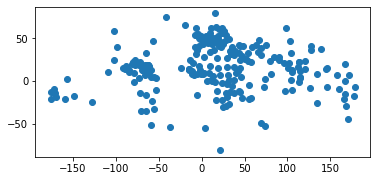

In [213]:
gdf.plot()

In [214]:
# Change the value of Global_SPI_ter to 42
gdf['Global_SPI_ter'] = 42
gdf.head(5)

,GID_0,NAME_0,Area_Country,x,y,jpg_url,has_priority,has_raisg,GlobalID,max_highlited_sp,...,mammals_mar,fishes_mar,endemic_mammals_mar,endemic_fishes_mar,nspecies_mar,total_endemic_mar,Area_EEZ,Global_SPI_mar,filter_similar_mar,geometry
0,ABW,Aruba,181.94,-69.97,12.51,https://live.staticflickr.com/1952/31416683438...,1.0,0.0,fe9f6eb0-f4f8-4f29-875a-5cbb3219e4e5,4.0,...,30,1648,0,0,1678,0,29970.30,26,"{""filter_Area_Country"": [""CUW"", ""GRD"", ""LVA"", ...",POINT (-69.97024 12.50914)
1,AFG,Afghanistan,643857.48,66.03,33.83,https://p1.pxfuel.com/preview/967/12/53/afghan...,1.0,0.0,193ba976-0e5a-4cf6-9b09-d00bf83f4557,5.0,...,0,0,0,0,0,0,NaN,nan,NaN,POINT (66.02960 33.82843)
2,AGO,Angola,1247421.58,17.58,-12.34,https://live.staticflickr.com/3787/13698381215...,1.0,0.0,174ce788-4f67-4ae0-922f-d2ddac87f8c3,24.0,...,46,1372,0,0,1418,0,495859.76,26,"{""filter_Area_Country"": [""NFK"", ""BMU"", ""CCK"", ...",POINT (17.57802 -12.33827)
3,AIA,Anguilla,83.30,-63.05,18.21,https://live.staticflickr.com/8063/8194570372_...,1.0,0.0,9f5f24d8-8b21-49a8-8f55-90b47cf63e7b,2.0,...,25,1508,0,0,1533,0,90157.96,26,"{""filter_Area_Country"": [""ERI"", ""AZE"", ""FIN"", ...",POINT (-63.05402 18.21492)
4,ALA,Åland,1506.26,19.97,60.24,https://p1.pxfuel.com/preview/294/670/561/alan...,1.0,0.0,2b45351b-a335-490e-914e-7748d4f41f66,1.0,...,0,0,0,0,0,0,NaN,nan,NaN,POINT (19.96770 60.24130)


In [215]:
gdf.to_csv('/Users/sofia/Documents/HE_Data/NRC/NRC_2024/NRC_final_20240315.csv')
gdf.to_file('/Users/sofia/Documents/HE_Data/NRC/NRC_2024/NRC_final_20240315.geojson', driver='GeoJSON')